# Modèle de **mélanges gaussiens** pour la génération de données
## 1 Modèle de mélange

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


### T1
---  
On sait que $\mathbb{P}[Z=k] = \pi_k$

Soit $f_k(x;\mu_k,\Sigma_k) = \frac{1}{(2\pi)^{k/2}\,|\Sigma|^{1/2}}\,
\exp\!\bigl[-\tfrac12\,(x-\mu)^\top \Sigma^{-1}(x-\mu)\bigr],\qquad x \in \mathbb R$

Donc, $f_k(x;\mu_k,\Sigma_k) = f_{X\mid Z = k}(x )$
  
Par la loi totale de probabilité appliquée aux densités :

$f_X(x)=\sum_{k=1}^K \mathbb{P}[Z=k] \; f_{X\mid Z}(x\mid k)=\sum_{k=1}^K \pi_l f_{\mu_k,\Sigma_l}(x).$
   
La somme finie de densités, pondérée par des poids positifs qui somment à 1, est bien une densité (positive partout et intégrale égale à 1).

### S1
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
import sklearn.datasets

rng = np.random.default_rng(42)

In [2]:
class GaussianMixtureModel:
    d: int
    weights_: np.ndarray
    means_: np.ndarray
    covariances_: np.ndarray
    def __init__(self, d):
        self.d = d
    
    def set_params(self, weights, means, covariances):
        if len(means[0]) != self.d or len(covariances[0]) != self.d:
            raise ValueError(f"Length of weights, means, and covariances must match {self.d}.")
        if len(weights) != len(means) or len(weights) != len(covariances):
            raise ValueError("Weights, means, and covariances must have the same number of components.")
        self.weights_ = np.array(weights)
        self.means_ = np.array(means)
        self.covariances_ = np.array(covariances)

In [3]:
def plot_multivariate_normal(K, theta, n):
    Z = rng.choice(K, size=n, p=theta.weights_) # K will be 1 unity less than the real index of the model 
    X = np.zeros((n, K - 1))
    for k in range(K):
        indices = np.where(Z == k)[0]
        for index in indices:
            X[index] = rng.multivariate_normal(theta.means_[k], theta.covariances_[k])
    return X, Z


Text(0.5, 1.0, 'Multivariate Normal Samples from GMM')

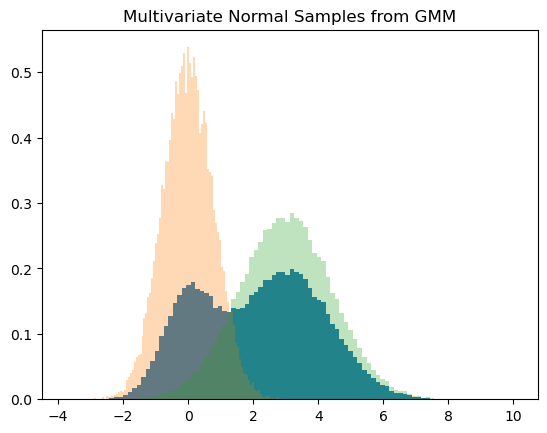

In [4]:
gmm = GaussianMixtureModel(d=1)
gmm.set_params(
    weights=[0.3, 0.7],
    means=[[0], [3]], 
    covariances=np.array([[[0.6]], [[2.0]]])
)
data, Z = plot_multivariate_normal(2, gmm, 100000)
plt.hist(data, bins=100, density=True)
X1 = data[Z == 0]
X2 = data[Z == 1]
plt.hist(X1, bins=100, density=True, alpha=0.3, label='Component 1')
plt.hist(X2, bins=100, density=True, alpha=0.3, label='Component 2')
plt.title('Multivariate Normal Samples from GMM')

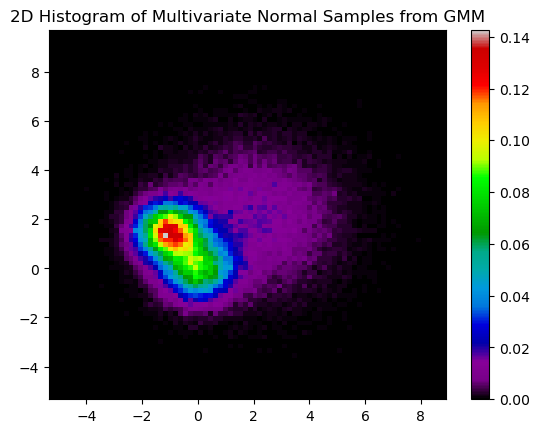

In [5]:
gmm = GaussianMixtureModel(d=2)
gmm.set_params(
    weights=[0.3, 0.3, 0.4],
    means=[[0, 0], [2, 2], [-1, 1.5]], 
    covariances=np.array([[[0.6, 0], [0, 0.6]], [[3.0, 0], [0, 3.0]], [[0.5, 0], [0, 0.5]]])
)
data, Z = plot_multivariate_normal(3, gmm, 100000)
# plt.hist(X[:,0], bins=100, density=True)
# plt.title('distribution of first dimension for d = 2')
# plt.show()
plt.hist2d(data[:,0], data[:,1], bins=(80,80), density=True, cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.title('2D Histogram of Multivariate Normal Samples from GMM')
plt.show()

## 2 Algorithme d'estimation

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\pi_k0$ et $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


In [6]:
def vraisemblance(k, X, theta):
    vraisemblance = 0.0
    for j in range(k):
        multinormal = multivariate_normal(mean=theta.means_[j], cov=theta.covariances_[j])
        for point in X:
            vraisemblance += math.log(multinormal.pdf(point) * theta.weights_[j])


    return vraisemblance

### T2

Calcul de la densité $p_{\theta}$ du couple $(Z,X)$:

Par définition, pour  $k \in \{1, ... , K\}$  la variable  $X \mid Z = k$  suit une loi normale de paramètre  $(\mu_{k},\Sigma_{k})$ de fonction de répartition $f_{\mu_k, \Sigma_k}$.

Soit $k \in \{1, ..., K\}$  et  $x \in \mathbb{R}$

Par définition de la fonction densité conditionnelle : $$f_{X \mid Z = k}(x) = \frac{p_{\theta}(k,x)}{\mathbb{P}_{\theta}(Z = k)}$$

Or $\mathbb{P}_{\theta}(Z = k) = \pi_k$

Donc $$p_{\theta}(k,x) = \pi_k f_{\mu_k,\Sigma_k}(x)$$
 

### T3

Soit $k \in \{1, ..., K\}$  et  $x \in \mathbb{R}$

Par définition  $\mathbb(P)_{\theta}(Z = k \mid X = x) = \frac{p_{\theta}(k,x)}{f_X(x)}$

On substitue alors les expressions au numérateur et au dénominateur obtenues respectivement en T2 et T1.

Ainsi $$\mathbb{P}_{\theta}(Z = k \mid X = x) = \frac{ \pi_k f_{\mu_k,\Sigma_k}(x) }{ \sum_{l=1}^K \pi_l f_{\mu_l,\Sigma_l}(x) }$$


### T4

On cherche $\hat{\theta} = (\hat{\boldsymbol{\pi}},\hat{\boldsymbol{\mu}},\hat{\boldsymbol{\Sigma}})$ qui maximise la fonction $F$ suivante :

$$ F(\theta) = \sum_{i=1}^{n}{\log p_{\theta}(z_i,x_i)} $$
$$ F(\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sum_{i=1}^{n}{\log(\pi_{k_i})} + \sum_{i=1}^{n}{\log(f_{\mu_i,\Sigma_i}(x_i))}$$

L'influence de $\boldsymbol{\pi}$ n'apparaît que dans le premier terme. On peut donc trouver $\hat{\boldsymbol{\pi}}$ en ne s'intéressant pour l'instant qu'à la fonction suivante :

$$ G(\boldsymbol{\pi}) = \sum_{i=1}^{n}{\log(\pi_{z_i})} $$

On simplifie cette expression :

$$ \begin{align*} G(\boldsymbol{\pi}) &= \sum_{k=1}^{K}{ \sum_{\substack{ i = 1 \\ z_i = k }}^{n}{\log(\pi_{z_i})} } \\ &= \sum_{k=1}^{K}{n_k\log(\pi_k)} \end{align*} $$

On cherche donc le point de   $ \{ \boldsymbol{\pi} / \sum_{k=1}^{K} \pi_k  = 1 \} $   qui maximise G.

En posant C la fonction définie par   $ C(\boldsymbol{\pi}) = \sum_{k=1}^{K} \pi_k  - 1 $ , on sait que $\hat{\boldsymbol{\pi}}$ vérifie les deux conditions suivantes :

$$ \left\{ \begin{align*} \exists \lambda, \nabla G(\hat{\boldsymbol{\pi}}) &= \lambda \nabla C(\hat{\boldsymbol{\pi}}) \\  C(\hat{\boldsymbol{\pi}}) &= 0 \end{align*} \right. $$

On pose alors   $ H(\boldsymbol{\pi}, \lambda) = G(\boldsymbol{\pi}) - \lambda C(\boldsymbol{\pi}) $  ainsi : 

$$ \nabla H(\boldsymbol{\pi}, \lambda) = \left( \begin{array}{c} \nabla G(\boldsymbol{\pi}) - \lambda \nabla C(\boldsymbol{\pi}) \\ -C(\boldsymbol{\pi})  \end{array} \right) $$

On cherche donc les solutions de $ \nabla H(\boldsymbol{\pi}, \lambda) = 0 $


Soit $ k \in \{1, K\} $

$$\frac{\partial H}{\partial \pi_k}(\boldsymbol{\pi}, \lambda) = \frac{n_k}{\pi_k} - \lambda $$

$$ Donc \quad \hat{\pi_k} = \frac{n_k}{\lambda} $$

$$Or \quad \frac{\partial H}{\partial \lambda}(\hat{\boldsymbol{\pi}}, \lambda) = \sum_{k=1}^{K} \hat{\pi_k}  - 1 = 0 $$

$$Ainsi \quad 1 = \sum_{k=1}^{K} \frac{n_k}{\lambda} $$

$$ \lambda = \sum_{k=1}^{K} n_k $$

$$ \lambda = n $$

On obtient donc  $ \hat{\pi_k} = \frac{n_k}{n} $  avec  $ n_k = \sum_{i=1}^{K} \mathbb{1}_{z_i=k} $




On s'intéresse maintenant à trouver $\hat{\boldsymbol{\mu}}$. On sait notamment que :

$$ \begin{align*} 0 = \frac{\partial F}{\partial \mu_k}(\hat{\boldsymbol{\theta}}) &= \sum_{\substack{i=1 \\ z_i = k}}^{n}{\frac{\partial}{\partial \mu_k}(\log(f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i)))} \\
&= \sum_{\substack{i=1 \\ z_i = k}}^{n}{\frac{-(x_i-\hat{\mu_k}) f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i)}{f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i)}} \\
&= \sum_{\substack{i=1 \\ z_i = k}}^{n}{\hat{\mu_k}-x_i} \\
&= n_k \hat{\mu_k} - \sum_{\substack{i=1 \\ z_i = k}}^{n}{x_i} \\
Donc \quad \hat{\mu_k} = \frac{1}{n_k} \sum_{i=1}^{n}{\mathbb{1}_{z_i=k}x_i}
\end{align*}$$


On procède de même pour déterminer $\hat{\boldsymbol{\Sigma}}$. Pour $\mu$, $\Sigma$ et $x$ réels quelconques on a :

$$ f_{\mu, \Sigma}(x) = \frac{1}{\sqrt{2\pi \Sigma}}\exp{-\frac{(x_\mu)^2}{2\Sigma}} $$

Ainsi :

$$ \begin{align*} 0 = \frac{\partial F}{\partial \Sigma_k}(\hat{\boldsymbol{\theta}}) &= \sum_{\substack{i=1 \\ z_i = k}}^{n}{\frac{\partial}{\partial \Sigma_k}(\log(f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i)))} \\
&= \sum_{\substack{i=1 \\ z_i = k}}^{n}{\frac{1}{f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i)}}( - \frac{1}{2\hat{\Sigma_k}} + \frac{(x_i-\hat{\mu})^2}{2\hat{\Sigma_k}^2}) f_{\hat{\mu_k},\hat{\Sigma_k}}(x_i) \\
&= \frac{1}{2\hat{\Sigma_k}}\sum_{\substack{i=1 \\ z_i = k}}^{n}{\frac{(x_i-\mu)^2}{\hat{\Sigma_k}} -1} \\
Donc \quad \hat{\Sigma_k} = \frac{1}{n_k} \sum_{i=1}^{n}{\mathbb{1}_{z_i=k}(x_i-\mu_k)^2}
\end{align*}$$





In [7]:
def thetaEstimation(data, clusters, k):
    if len(clusters) != len(data):
        raise ValueError("The number of clusters must match the number of data points.")

    weights = np.zeros(k)
    means = np.zeros((k, data.shape[1]))
    covariances = np.zeros((k, data.shape[1], data.shape[1]))

    for cluster in range(k):
        idx = np.where(clusters == cluster)[0]
        if len(idx) == 0:
            means[cluster] = np.zeros(data.shape[1])
            covariances[cluster] = np.eye(data.shape[1])
            continue
        weights[cluster] = len(idx) / len(clusters)
        means[cluster] = np.mean(data[idx], axis=0)
        covariances[cluster] = np.cov(data[idx].T, bias=True)
        

    gmm = GaussianMixtureModel(data.shape[1])
    gmm.set_params(weights, means, covariances)
    return gmm


In [8]:
def clustersEstimation(data, theta, k):
    clusters = np.zeros(len(data))
    vraisemblances = np.zeros(k)
    for i in range(len(data)):
        point = data[i]
        for j in range(k):
            vraisemblances[j] = multivariate_normal.pdf(point, mean=theta.means_[j], cov=theta.covariances_[j]) * theta.weights_[j]
        clusters[i] = np.argmax(vraisemblances)
    return clusters
        
            


In [9]:
def initialEstimation(data, k, loops = 5):
    centres = data[:k]
    zInitial = np.zeros(len(data))
    for i in range(loops):
        for i in range(len(data)):
            distances = np.zeros(len(centres))
            for j in range(len(centres)):
                distances[j] = np.linalg.norm(data[i] - centres[j])
            if distances[0] <= distances[1] and distances[0] <= distances[2]:
                zInitial[i] = 0
            elif distances[1] <= distances[2]:
                zInitial[i] = 1
            else:
                zInitial[i] = 2
        centres = np.mean(data[zInitial == 0], axis=0), np.mean(data[zInitial == 1], axis=0), np.mean(data[zInitial == 2], axis=0)
    return zInitial

In [10]:
from matplotlib.colors import to_rgb, to_hex, ListedColormap

def hex_gradient(start_hex: str, end_hex: str, n: int):
    """Return a list of n hex strings forming a linear gradient."""
    c1, c2 = np.array(to_rgb(start_hex)), np.array(to_rgb(end_hex))
    grads = (1 - np.linspace(0, 1, n)[:, None]) * c1 + np.linspace(0, 1, n)[:, None] * c2
    return [to_hex(c) for c in grads]

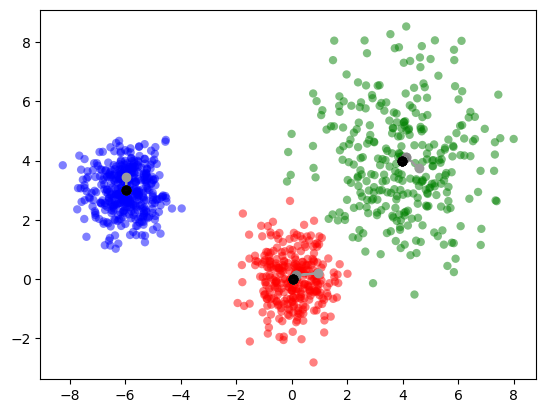

In [11]:
Test_skLearn = False
PlotClusters = True

if Test_skLearn:
    data = sklearn.datasets.make_blobs(centers=3, n_samples=1000)[0]
else:
    gmm = GaussianMixtureModel(d=2)
    gmm.set_params(
        weights=[0.3, 0.3, 0.4],
        means=[[0, 0], [4, 4], [-6.0, 3.0]], 
        covariances=np.array([[[0.6, 0], [0, 0.6]], [[3.0, 0], [0, 3.0]], [[0.5, 0], [0, 0.5]]])
    )
    data, Z = plot_multivariate_normal(3, gmm, 1000)
    
z = initialEstimation(data, 3, 1)
theta = thetaEstimation(data, z, 3)

arrow_colors = hex_gradient("#9c9c9c", "#000000", 16)
meansPrev = data[:3]
plt.scatter(meansPrev[:,0], meansPrev[:, 1], c=arrow_colors[0], marker='o', zorder = 1)

for _ in range(15):
    plt.scatter(theta.means_[:, 0], theta.means_[:, 1], c=arrow_colors[_ + 1], marker='o', zorder = 1)
    for i in range(3):
        plt.arrow(meansPrev[i,0], meansPrev[i, 1], 
                   (theta.means_[i, 0] - meansPrev[i,0]), (theta.means_[i, 1] - meansPrev[i,1]),
                     color=arrow_colors[_], linewidth=1.5 , zorder = 1)

    meansPrev = theta.means_.copy()
    theta = thetaEstimation(data, z, 3)
    z = clustersEstimation(data, theta, 3)

color_map = {0: 'red', 1: 'green', 2: 'blue'}
for i in range(3):
    for j in range(len(data)):
        if z[j] == i:
            plt.scatter(data[j,0], data[j,1], color=color_map[i], edgecolors = 'none', label=f'Cluster {i}', alpha=0.5, zorder = -1)
plt.show()


# 3 Application à des données réelles

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.mixture import GaussianMixture as GMM

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

### S4.
Le nombre d'images de la base de donnée nous est donnée par la première composante de `digits.data.shape` (la seconde indiquant le nombre de pixel dans chaque image).

Ainsi la base de donnée contient 1797 images

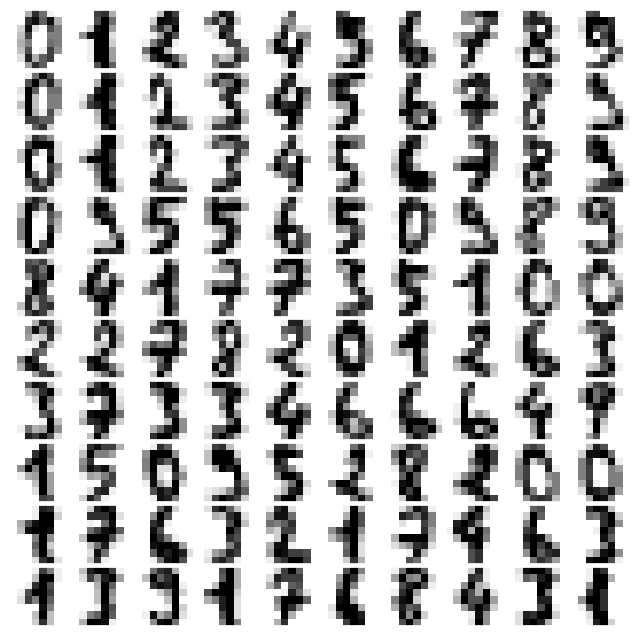

In [14]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

### S5.
En toute généralité, la fonction `plot_digits` permet d'afficher selon une grille de 10 par 10 les 100 premières images d'un tableau `data` contenant des images en niveau de gris de 8x8 pixels. En l'occurrence elle permet d'afficher les 100 premières images de chiffre de la base de données

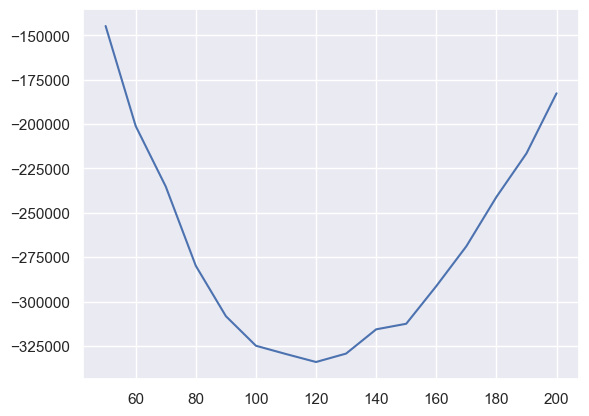

In [15]:
data = digits.data

K_components = np.arange(50, 210, 10)
models = [GMM(K, covariance_type='full', random_state=0)
          for K in K_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(K_components, aics);

### S6.
Le bloc ci-dessus permet de calculer le critère d'information d'Akaike (AIC) pour différentes valeurs du paramètre $K$. Il permet donc d'évaluer la pertinence d'un modèle de mélange de $K$ gaussienne pour décrire la répartition de la couleur dans cette base d'images de chiffre

### S7.

On réécrit ici la fonction `vraisemblance` de la question S2 de sorte à ce qu'elle utilise plus efficacement l'implémentation du modèle gaussien du module `sklearn`

In [16]:
def vraisemblance_(X, gmm:GMM):
    return np.sum( np.log( gmm.predict_proba(X).dot(gmm.weights_) ) )

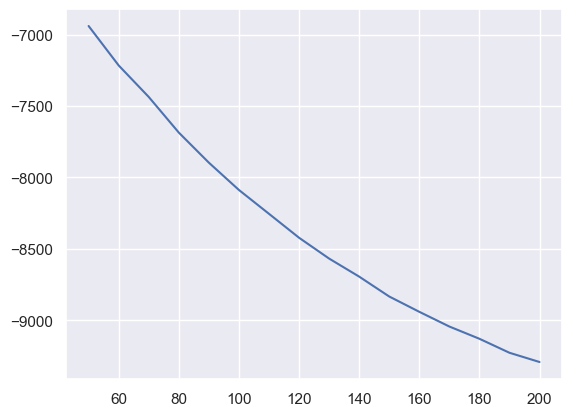

In [17]:
fitted_models = [ model.fit(digits.data) for model in models ]
vraisemblances = [ vraisemblance_( data, model )  for model in fitted_models ]

plt.figure()
plt.plot(K_components, vraisemblances)
plt.show()

La vraisemblance est ainsi décroissante de du nombre de paramètre utilisés. Cela se comprend par le fait qu'en ajoutant des clusters, "répartit" plus les issues possibles. Ainsi les valeurs des densités sont plus petites. Représenter la vraisemblance en fonction du nombre de paramètre ne semble donc pas nous aider à affiner le modèle.

### S8.

In [ ]:
K = 110
gmm = GMM(K, covariance_type='full', random_state=0).fit(data)

X_new= gmm.sample(100)[0]
plot_digits(X_new)
plt.show()


ValueError: could not broadcast input array from shape (64,) into shape (109,)